In [1]:
# %load d:/learn/python/pending.py
import sys 
sys.path.append("d:/learn/python/") 

# import calc 

# py2neo

In [2]:
# 
import pymysql
from py2neo import Graph, Node, Relationship, NodeSelector, remote
import traceback
import csv
import sys  


graph = Graph(
    "http://211.87.234.115:7474",
    username="neo4j",
    # password="neo4jSPLab
    password='123456'
)
selector = NodeSelector(graph)



# load csv convert to dict
'''
ercsv[abstract] = {
    'tables' :  paragraph[1][1].split('-'),
    'tables_zh' : paragraph[2][1].split('-'),

    'items' : paragraph[1][2:],
    'items_zh' :  paragraph[2][2:],
    'layers' : layers,
    'layers_zh' : layers_zh,
    'dim' : dim,
    'sql' : sql,
    'nodes' : nodes ,
    'relations' :  relations
}
'''


def write(*string, path ="./default.log" ):
    with open(path , "a+") as file:
        for i in string:
            print(i, file=file)
        print("", file=file)
        print("==================", file = file)
        traceback.print_exc(file = file)

        print('========================================================\n\n',file = file)

# return ( (row,,,), (row2, ,,) )
# sql right, null --> ()
# sql wrong return None
# 只有在SQL出错才写log -- ./sql_wrong.log
def query(sql):
    connect = pymysql.connect(
        host='211.87.234.115',  # must be
        port=3306,
        user='splabuser',
        passwd='111111',
        db='circ_report',
        charset='utf8'
    )
    try:
        with connect.cursor() as cursor:
            # 执行SQL语句
            cursor.execute(sql)
            # 获取所有记录列表
            results = cursor.fetchall()
            # connect.commit()
            return results
    except Exception as e:
        write("wrong sql ", sql, path = './sql_wrong.log')
        return None

    finally:
        connect.close()

'''
 "./sql_parameters.log")   
 "./assets_sql_wrong.log")
"./assets_sql_null.log")
 "./assets_sql_000.log"

 if seccessiful return True else return None
 '''
def add_assets(node_member, items, sql, parameters, date, nodes, relations):
    try:
        # 有问题就插入 '0' 保证 item 不空
        if sql.count("%s") != len(parameters):
            insert_values(node_member, items, [])
            print("add_assets,  wrong sql, parameters", parameters, sql)
            return 

        sql_results = query(sql % parameters)
        
        # 说明SQL有问题，一般不会发生，所以print
        if sql_results is None :
            print("sql None - member_node:",node_member['ELE_NAME'], " - dwbh date table .. is  ", 
                parameters, sql % parameters,  )
        elif sql_results is ():
            # write("sql return () ",node_member['ELE_NAME'], " - dwbh date table .. is  ", 
            #     parameters,sql % parameters, path = 'asset_sql_().log'  )
            pass

        count_0 = 0
        to_insert_values = []
        for row in sql_results:
            # print ("========================================================")

            # 0 is the total value
            # 比较特殊的Mr 03 债券节点里面的名称都是'0'
            # if row.count('0') > 3:
            if row[0] == '0' and  row.count('0') > 2 :
                to_insert_values.append(row)
                count_0+=1

            else:
                tx = graph.begin()
                no = nodes[0]
                rel = relations[0]

                # asset node
                label = no[0].split(':')[1]
                property_keys = [items[int(i)] for i in no[1:]]
                values = [row[int(i)] for i in no[1:]]
                properties = {}
                for i in range(len(property_keys)):
                    properties[property_keys[i]] = values[i]
                asset_node = Node(label, **properties)

                # relation node
                label = 'own_amount'
                property_keys = [items[int(i)] for i in rel[1:]]
                values = [row[int(i)] for i in rel[1:]]
                properties = {}
                for i in range(len(property_keys)):
                    properties[property_keys[i]] = values[i]
                amount_node = Node(label, **properties)

                # link these two together

                try:
                    tx.merge(asset_node)
                    tx.create(amount_node)
                    tx.create(Relationship(node_member, "own", amount_node))
                    tx.create(Relationship(amount_node, "own", asset_node))
                    tx.commit()
                except Exception as e:
                    print('neo4j transaction failed')
                    print(traceback.print_exc())
                else:
                    # print('neo4j transaction success-- one row of RDB success')
                    pass
            
        # end of add_assets
        if count_0 > 1:
            # write("sql wrong , '0' more than one ",node_member['ELE_NAME'], " - dwbh date table .. is  ", 
            # parameters, path = "./assets_sql_000.log")
            insert_values(node_member, items, [])
            print("0 太多。。。to_insert_values",to_insert_values , items, parameters, sql % parameters)


        elif count_0 ==1:
            insert_values(node_member, items, to_insert_values[0])  
        # 保证，最终有item， 不会漏
        elif count_0 == 0:
            insert_values(node_member, items, [])
        return True
    except Exception as e:
        print("========================================================")
        print("appending assets (node_member, items, sql, parameters, date, nodes, relations):")
        print(node_member, items, sql, parameters, date, nodes, relations)
        traceback.print_exc()
        print("========================================================")
  
# create linkitems relation -> items node
# 'insert_values_null.log'
#  if seccessiful return True else return None
def insert_values(node_member, items, values, label= 'item', rel_label= 'linkitem' , debug = 1):
    # print(items, values)
    # 假如为空就插入'0'  ； 这样能够省很多事！！！！****
    if values is None or len(values) == 0 or len(values) != len(items):
        # write("values are None or () " , node_member['ELE_NAME'], path= 'insert_values_null.log')
        values = ['0' for i in range(len(items))]


    nodes = []
    for i,v in zip(items, values):
        pro = {
            'ELE_NAME' : i,
            'value' : v
        }
        # print(pro)
        nodes.append(Node(label, **pro))

    # ??
    relations = [Relationship(node_member, rel_label, node) for node in nodes]
    for node in nodes:
        if not isinstance(node, Node):
            print(node , "is not Node !!! insert_values")
    # for r in relations:
    #     print(r)
    tx = graph.begin()
    try:
        # for n in nodes:
        #     tx.create(n)
        for r in relations:
            # print("*******", r)
            tx.create(r)
        tx.commit()
    except Exception as e:
        print("============================ com,date ")
        global com, date
        print(com,date)
        print('insert values failed  node_member, items, values, ')
        print(node_member['ELE_NAME'], items, values)
        print("============================")
        for n in nodes:
            print("*******nodes name ",n['ELE_NAME'])
        traceback.print_exc()
    return True
# return nodes
def create_son_nodes(node, label, rel_label):
    # id id id
    id = node['id']
    records = graph.run("match(n:template)-[:contains]->(m:template) where id(n) = %d return m  " % (id))
    node_sons = []
    for r in records:
        node_sons.extend(r.subgraph().nodes())

    # create nodes
    nodes = []
    tx = graph.begin()
    for n in node_sons:
        new = Node(label, ELE_NAME=n['ELE_NAME'], LABEL_ZH=n['LABEL_ZH'], id=remote(n)._id)
        tx.create(new)
        nodes.append(new)
    tx.commit()

    # create relationships
    tx = graph.begin()
    for w in nodes:
        # create relation
        tx.create(Relationship(node, rel_label, w , ELE_NAME = node['ELE_NAME']))
    tx.commit()
    return nodes


def read_csv(path='./er.csv'):
    with open(path, encoding="gbk") as csvfile:
        spamreader = csv.reader(csvfile, quotechar='"')
        paragraph = []  # 每个abstract表的所有要素
        ercsv = {}
        # csvreader里面是二维元组，行-列
        count = 0
        for cols in spamreader:

            # print(cols)
            ###
            if cols == [] or cols[0].strip() == '':
                continue
            # count +=1
            # if count >7: break
            # print (cols)
            # 完整的一段，开始处理一张abstract表
            try:
                if cols[0] == 'end':
                    abstract = paragraph[1][0]
                    abstract_zh = paragraph[2][0]
                    layers = []
                    layers_zh = []
                    dim = ''
                    sql = ''
                    nodes = []
                    relations = []

                    for row in paragraph:
                        if row[0] == 'layer':
                            # layers.append(row[1].split('-'))
                            layers.append([rs.strip() for rs in row[1].split('-') ])
                            # has dim
                            # if len(row) >2 :
                            #     dim.append(row [3])
                        # elif row[0] == 'layers_zh':
                        elif row[0] == 'layer_zh':          
                            # layers_zh.append(row[1].split('-'))
                            layers_zh.append([rs.strip() for rs in row[1].split('-') ])

                        elif row[0] == 'sql':
                            sql = '#' +abstract_zh +'\n\n' +row[1]
                            # print(sql)`
                            if len(row) > 2:
                                dim = row[2]
                            else:
                                dim = ''
                        elif row[0].split(":")[0].strip() == 'node':
                            nodes.append(row)
                        elif row[0].split(":")[0].strip() == 'relation':
                            relations.append(row)

                    ercsv[abstract] = {
                        'abstract_zh' : abstract_zh,
                        # 'tables': paragraph[1][1].split('-'),
                        'tables': [ i.strip() for i in paragraph[1][1].split('-')],

                        'tables_zh': paragraph[2][1].split('-'),
                        'items': paragraph[1][2:],
                        'items_zh': paragraph[2][2:],
                        'layers': layers,
                        'layers_zh': layers_zh,
                        'dim': dim,
                        'sql': sql,
                        'nodes': nodes,
                        'relations': relations
                    }
                    paragraph = []
                else:
                    c2 = [col.strip() for col in cols if col.strip() != '']
                    if c2 != []:
                        paragraph.append(c2)
            except Exception as e:
                print(traceback.print_exc())

    return ercsv

# if values 有问题 return false  正确则返回True
def values_sql_log(values, debug  =1):
    if values is None : 
        if debug > 0:
            write("sql values None --   ", com, date, qn['ELE_NAME'], path = './layer1_sql.log')
        return False
    elif values == ():
        if debug > 0:
            write("sql values is () --   ", com, date, qn['ELE_NAME'], path = './layer1_sql.log')
        return False
    elif len(values) != 1:
        if debug > 0:
            write("sql values len  >1 --   ", com, date, qn['ELE_NAME'], path = './layer1_sql.log')
        return False

    else :
        return True

# return  fathers list, if no father then []
def find_father_node(son_node, father_label = 'instance', son_label ='instance', rela_label= 'link'):
    try:
        cur = graph.run(''' 
            match (m:%s)-[:%s]->(n:%s)
            where id(n) = %d
            return m                
         ''' %(father_label, rela_label, son_label, remote(son_node)._id))
        fathers =[]
        while cur.forward():
            father_node = list(cur.current().subgraph().nodes())[0] #??###
            fathers.append(father_node)
        return fathers
    except Exception as e:
        write("can't find father", path = './no_father.log')
        return None




In [4]:
import pymysql
from py2neo import Graph, Node, Relationship, NodeSelector, remote
import traceback
import csv
import sys
import json


# traceback.print_exc()
graph = Graph(
    "http://211.87.234.115:7474",
    username="neo4j",
    # password="neo4jSPLab
    password='123456'
)
selector = NodeSelector(graph)

# return ( (row,,,), (row2, ,,) )
# sql right, null --> ()
# sql wrong return None
# 只有在SQL出错才写log -- ./sql_wrong.log
def query(sql):
    connect = pymysql.connect(
        host='211.87.234.115',  # must be
        port=3306,
        user='splabuser',
        passwd='111111',
        db='circ_report',
        charset='utf8'
    )
    try:
        with connect.cursor() as cursor:
            # 执行SQL语句
            cursor.execute(sql)
            # 获取所有记录列表
            results = cursor.fetchall()
            # connect.commit()
            return results
    except Exception as e:
        write("wrong sql ", sql, path = './sql_wrong.log')
        return None

    finally:
        connect.close()


# path include： abs，item 不能少 ： abstract - members - item
# return path's node,
# create = True 假如没有的话就会创建节点返回； 慎用
# 只能创建明细表的item，因为总表的item总是全的
# 只有item才行
def merge_item(path, com, date, create = False ):
    S = ["TableOfSolvencyStatusAbstract",
         "TableOfAvailableCapitalAbstract",
         "TableOfAdmittedAssetsAbstract",
         "TableOfAdmittedLiabilitiesAbstract",
         "TableOfMinimumCapitalAbstract", ]

    spl = path.split('-')
    spl = [s.strip() for s in spl]
    abstract = spl[0]
    members = spl[1:-1]
    item = spl[-1]

    cql_piece = ''
    for i in range(len(members)):
        c = "-[:link]->(m%d:instance{ELE_NAME : '%s'})" % (i, members[i])
        cql_piece = cql_piece + c

    # 总表里面是需要模糊查询的； 当时设计结构时候没有和刘方铮说清楚
    if abstract in S:
        cql =  '''
            match (c:company{dwzd_bh :'%s'})-->(d:date{inst_date: '%s'})-[:link*]->
                (a:instance{ELE_NAME : '%s'}), 

             p= shortestPath(
                (a)-[:link*0..3]->(ii:instance)
            ), 
            (ii)%s-[:linkitem]->(i:item{ELE_NAME:'%s'}) 
            where  size([ i in nodes(p) where i.ELE_NAME=~'.*Abstract']) <2
            return i'''% (com, date, abstract, cql_piece, item)
        # print("总表的cql============================ ", cql)
    else:
        cql = '''
            match p= (c:company{dwzd_bh :'%s'})-->(d:date{inst_date: '%s'})-[:link*]->
            (a:instance{ELE_NAME : '%s'})%s
            -[:linkitem]->(i:item{ELE_NAME:'%s'})
            return i
        ''' % (com, date, abstract, cql_piece, item)

    try:
        cur = graph.run(cql)
        items_node = []
        while cur.forward():
            ii = list(cur.current().subgraph().nodes())[0]
            items_node.append(ii)
        if len(items_node) > 1:
            print("============================")
            print(path, com, date)
            print(cql)
            raise Exception("========merge_item====================找到不止一个item ")
        # 没找到， 是否创建
        elif len(items_node) < 1  :
            print("****************** 没找到*************")
            print(path, '\n', cql)
            print("========================================================")
            if create:
                if abstract not in S :
                    # create item add default value '0' ； created property - merge 1
                    mi = len(members) - 1
                    if mi < 0:
                        cql = '''
                            match p= (c:company{dwzd_bh :'%s'})-->(d:date{inst_date: '%s'})-[:link*]->
                            (a:instance{ELE_NAME : '%s'})
                            create (a)-[:linkitem]->(ii:item{ELE_NAME: '%s', value : '0', merge: 1})
                            return ii
                        ''' % (com, date, abstract, item)
                    else:
                        cql = '''
                            match (c:company{dwzd_bh :'%s'})-->(d:date{inst_date: '%s'})-[:link*]->
                                (a:instance{ELE_NAME : '%s'}), 
                            p= (a)-[:link*0..3]->(ii:instance)%s
                            where size([ i in nodes(p) where i.ELE_NAME=~'.*Abstract']) <2
                            create (m%d)-[:linkitem]->(ii:item{ELE_NAME: '%s', value : '0', merge: 1})
                            return ii
                        ''' % (com, date, abstract, cql_piece, mi, item)

                    cur = graph.run(cql)
                    if cur.forward():
                        print("--------merge get item ",path)
                        return cur.current().values()[0]
                    else:
                        raise Exception("insert merge item failure")
                else :
                    raise Exception("总表少item！ " + path)
            else:
                return None
        else:
            return items_node[0]
    except Exception as e:

        traceback.print_exc()
        # print("============================Exception cql", cql)
        return None

# 获取abstract下面节点： 包括abstract；
# path 结构和之前一样
def fetch_instance_node(path, com='000009', date='20161231' ):
    if len(path.split( '-')) > 1:
        S = ["TableOfSolvencyStatusAbstract",
             "TableOfAvailableCapitalAbstract",
             "TableOfAdmittedAssetsAbstract",
             "TableOfAdmittedLiabilitiesAbstract",
             "TableOfMinimumCapitalAbstract", ]



        node_names = path.split('-')
        node_names = [n.strip() for n in node_names]
        abstract = node_names[0]


        mem_cql_piece = ''' -[:link]->(m%d:instance{ ELE_NAME : '%s'})'''
        mem_cql = ''
        for i, name in enumerate(node_names[1:]):
            mem_cql += mem_cql_piece % (i, name)

        target_index = len(node_names) - 2

        # 总表里面是需要模糊查询的； 当时设计结构时候没有和刘方铮说清楚
        # 为了兼容模糊查询和非模糊查询
        # 单个member的总表
        # 
        # 模糊查询
        if abstract in S and  target_index== 0:
            cql =  '''
                match (c:company{dwzd_bh :'%s'})-->(d:date{inst_date: '%s'})-[:link*]->
                    (a:instance{ELE_NAME : '%s'}), 

                 p=  (a)-[:link*0..3]->(ii:instance{ELE_NAME : '%s'})
              
                where  size([ i in nodes(p) where i.ELE_NAME=~'.*Abstract']) <2
                return ii'''% (com, date, abstract, node_names[1])
        
        else:
            cql = '''
                match p= (c:company{dwzd_bh :'%s'})-->(d:date{inst_date: '%s'})-[:link*]->
                (a:instance{ELE_NAME : '%s'})%s
                return m%d
            ''' % (com, date, abstract, mem_cql, target_index)

        
        try:
            cur = graph.run(cql)
            if cur.forward():
                out_node = cur.current().values()[0]
                return out_node
            else:
                return None
        except Exception as e:
            traceback.print_exc()
            print(cql)
            return None
    elif len(path.split('-')) == 1:
        name = path
        cql = "match   (c:company{dwzd_bh : '%s'}) -[]->(d:date{inst_date : '%s'}) " \
              "-[:link*]-> (n:instance {ELE_NAME : '%s'}) return n" % (com, date, name)
        try:
            cur = graph.run(cql)
            if cur.forward():
                out_node = cur.current().values()[0]
                return out_node
            else:
                return None
        except Exception as e:
            traceback.print_exc()
            print(cql)
            return None
    else:
        print("请输入正确的path 格式")





# pycharts

In [5]:
from pyecharts import *
def getbar3d(name, x_axis, y_axis, data):
    bar3d = Bar3D(name, width=1100, height=700, title_pos = 'center', )
    bar3d.add("图例名称", x_axis, y_axis, data,
              is_visualmap=True, visual_range=[0, 200],
               grid3d_width=155, grid3d_height = 99, grid3d_depth=111, 
              # is_grid3d_rotate=True, grid3d_rotate_speed=3,
             legend_pos ='left',
              # visual_pos ='center',
             )
    return bar3d


# com.date.name

In [6]:

sql_dwzd_date  = ''' SELECT   distinct a.DWZD_BH AS '机构编号', a.INST_DATE AS '发生日期', b.y as name
         FROM psx_dw_instdata a , (
              select DWZD_BH as x, DWZD_MC  as y from rpt_dwzd where dwzd_bh in (
           SELECT   distinct a.DWZD_BH as bh
                 FROM psx_dw_instdata a
                 where length(a.DWZD_BH) = 6
         )) b
         where length(a.DWZD_BH) = 6 and a.DWZD_BH = b.x
          '''
results_dwzd_date = query(sql_dwzd_date)

# bar3d

In [10]:
# from calc import *

# cql = "match (n) return distinct labels(n) as las"
# las = graph.data(cql)
# # print(las)
# for la in las:
#     num = graph.data("match (n:%s) return count(distinct n) as count" % la['las'][0])[0]['count']
#     print(la['las'][0]+ '\t\t'+ str(num))


templ		1766
template		574
item		208800
instance		33292
date		58
reinsurance		4641
own_amount		82755
product		1651
company		23
equity		277
bond		4351
assets		4565
real_estate		137
overseas		1602
fund		2453
stock		4122
contract		59
convertible_bond		100
forex		66
security		1
calculate		7018


In [ ]:
threes = [
    "AvailableCapitalUnderSolvencyII",
    "MinimumCapitalUnderSolvencyII",
    "ComprehensiveSolvencyAdequacyRatio",]

datas = []
label_zh = []

for e in threes:
    data = []
    for com, date, dw_name in results_dwzd_date[:]:
    
        path = "TableOfSolvencyStatusAbstract-"+e + '-end'
        node = merge_item(path, com, date)
        value = float(node['value']) if node is not None and node.get('value') is not None else 0
        tmp = fetch_instance_node("TableOfSolvencyStatusAbstract-"+e)
        data.append([dw_name, date, value] )
    datas.append(data)
    label_zh.append(tmp['LABEL_ZH'])

com_name = set([ i[2] for i in results_dwzd_date])
com_name = list(com_name)

y_axis = [
    "20170630",
    "20170930",
    "20171231",
    "20161231",
    "20170331"
]

x_axis = com_name

In [30]:
from pyecharts import Bar3D
bar3d = Bar3D("three mix",width=1100, height=700, title_pos = 'center', )
for da,name in zip(datas, label_zh):
    # print(da, name)
    bar3d.add(label_zh, x_axis, y_axis, da,
              is_visualmap=True, visual_range=[0, 200],
               grid3d_width=155, grid3d_height = 99, grid3d_depth=111, 
              # is_grid3d_rotate=True, grid3d_rotate_speed=3,
             legend_pos ='left',
              # visual_pos ='center',
              # is_datazoom_show =True,
              mark_point=["max", "min"],
             )

bar3d

In [41]:
from pyecharts import Bar3D
from pyecharts import Page
grid = Grid()

bs = []
for da,name in zip(datas, label_zh):
    bar3d = Bar3D("three mix",width=1100, height=700, title_pos = 'center', )
    bar3d.add(label_zh, x_axis, y_axis, da,
              is_visualmap=True, visual_range=[0, 200],
               grid3d_width=155, grid3d_height = 99, grid3d_depth=111, 
              # is_grid3d_rotate=True, grid3d_rotate_speed=3,
             legend_pos ='left',
              # visual_pos ='center',
              # is_datazoom_show =True,
              mark_point=["max", "min"],
             )
    bs .append(bar3d)
    # grid.add(bar3d, grid_bottom="60%", grid_left="60%")
print(len(bs))
# grid.add(bs[0], grid_bottom="60%", grid_left='50%')
grid.add(bs[1], grid_top= '50%', grid_right = '50%')
grid.add(bs[2], grid_bottom= '50%', grid_right='50%')
grid

3


In [52]:
from pyecharts import Bar3D 
from pyecharts import Page
grid = Grid()

bs = []
for da,name in zip(datas, label_zh):
    bar3d = Bar3D("three mix",width=1100, height=700, title_pos = 'center', )
    bar3d.add(label_zh, x_axis, y_axis, da,
              is_visualmap=True, visual_range=[0, 200],
               grid3d_width=155, grid3d_height = 99, grid3d_depth=111, 
              # is_grid3d_rotate=True, grid3d_rotate_speed=3,
             legend_pos ='left',
              # visual_pos ='center',
              # is_datazoom_show =True,
              mark_point=["max", "min"],
             )
    bs .append(bar3d)
    # grid.add(bar3d, grid_bottom="60%", grid_left="60%")
    
# print([x[0] for x in datas[2]])  


print(len(bs))
# grid.add(bs[0], grid_bottom="60%", grid_left='50%')
grid.add(bs[1], grid_top= '50%', grid_right = '50%')
# grid.add(scatter, grid_bottom= '50%', grid_right='50%')
grid

3


In [67]:
scatter = Scatter("散点图示例")
scatter.add("B", [ x[0] for x in datas[2]], [ x[1] for x in datas[2]],extra_data= [ x[2] for x in datas[2]] 
            , xaxis_type="category", yaxis_type="category", 
            is_visualmap=True,
        visual_dimension=2, visual_orient='vertical',
        visual_type='size',visual_range =[0,7] , xaxis_rotate = -60,is_datazoom_show =True, datazoom_type='both',
        )

scatter

In [72]:
scatter = Scatter("散点图示例")
scatter.add("实际价值", [ x[0] for x in datas[0]], [ x[1] for x in datas[0]],extra_data= [ x[2] for x in datas[0]] 
            , xaxis_type="category", yaxis_type="category", 
            is_visualmap=True,
        visual_dimension=2, visual_orient='vertical',
        visual_type='size', xaxis_rotate = -60,is_datazoom_show =True, datazoom_type='both',
        )
scatter.add("最低资本", [ x[0] for x in datas[1]], [ x[1] for x in datas[1]],extra_data= [ x[2] for x in datas[1]] 
            , xaxis_type="category", yaxis_type="category", 
            is_visualmap=True,
        visual_dimension=2, visual_orient='vertical',
        visual_type='size' , xaxis_rotate = -60,is_datazoom_show =True, datazoom_type='both',
        )

scatter

In [84]:
grid = Grid(width= 1200, height=700)
scatter1 = Scatter("散点图示例")
scatter2 = Scatter("散点图示例")
scatter1.add("实际价值", [ x[0] for x in datas[0]], [ x[1] for x in datas[0]],extra_data= [ x[2] for x in datas[0]] 
            , xaxis_type="category", yaxis_type="category", 
            is_visualmap=True,
        visual_dimension=2, visual_orient='vertical',
        visual_type='size', xaxis_rotate = -60,is_datazoom_show =True, datazoom_type='both',
        )
scatter2.add("最低资本", [ x[0] for x in datas[1]], [ x[1] for x in datas[1]],extra_data= [ x[2] for x in datas[1]] 
            , xaxis_type="category", yaxis_type="category", 
            is_visualmap=True,
        visual_dimension=2, visual_orient='vertical',
        visual_type='size' , xaxis_rotate = -60,is_datazoom_show =True, datazoom_type='both',
        )
grid.add(scatter1 , grid_top="60%", grid_left='50%')
grid.add(scatter2 ,grid_bottom= '50%', grid_right='50%')
grid

In [85]:
grid.render()

### S05


In [25]:

datas = []
label_zh = []
elenames = [
    "MinimumCapitalForQuantifiableRisk",
    "MinimumCapitalForControlRisk",
    "AdditionalCapital",
    "MinimumCapitalUnderSolvencyII",
    "MinimumCapitalForInsuranceRiskOfLifeInsuranceBusiness",
    "MinimumCapitalForInsuranceRiskOfNonLifeInsuranceBusiness",
    "MinimumCapitalForMarketRisk",
    "MinimumCapitalForCreditRisk",
    "QuantifiableRiskDiversificationEffect",
    "LossAbsorptionOfSpecificInsuranceContract",
    "InsuranceRiskOfLifeInsuranceBusinessMinimumCapitalForIncidenceRisk",
    "InsuranceRiskOfLifeInsuranceBusinessMinimumCapitalForSurrenderRisk",
    "InsuranceRiskOfLifeInsuranceBusinessMinimumCapitalForExpenseRisk",
    "InsuranceRiskOfLifeInsuranceBusinessRiskDiversificationEffect",
    "InsuranceRiskOfNonLifeInsuranceBusinessMinimumCapitalForPremiumAndReserveRiskAfterRiskDiversification",
    "InsuranceRiskOfNonLifeInsuranceBusinessMinimumCapitalForCatastropheRisk",
    "InsuranceRiskOfNonLifeInsuranceBusinessRiskDiversificationEffect",
    "MarketRiskMinimumCapitalForInterestRateRisk",
    "MarketRiskMinimumCapitalForEquityPriceRisk",
    "MarketRiskMinimumCapitalForPropertyPriceRisk",
    "MarketRiskMinimumCapitalForOverseasFixedIncomeInvestmentAssetsPriceRisk",
    "MarketRiskMinimumCapitalForOverseasEquityInvestmentAssetsPriceRisk",
    "MarketRiskMinimumCapitalForExchangeRateRisk",
    "MarketRiskRiskDiversificationEffect",
    "CreditRiskMinimumCapitalForSpreadRisk",
    "CreditRiskMinimumCapitalForCounterpartyDefaultRisk",
    "CreditRiskRiskDiversificationEffect",
    "SpecificInsuranceContractAdjustedOfLossAbsorptionUpperLimitNotToBeTakenIntoConsideration",
    "UpperLimitForCapacityOfLossAbsorptionAdjustmentOfSpecificInsuranceContract",
]

for e in elenames:
    data = []
    for com, date, dw_name in results_dwzd_date:
    
        path = "TableOfMinimumCapitalAbstract-"+e + '-end'
        node = merge_item(path, com, date)
        value = float(node['value']) if node is not None and node.get('value') is not None else 0
        tmp = fetch_instance_node("TableOfMinimumCapitalAbstract-"+e)
        data.append([dw_name, date, value] )
    datas.append(data)
    label_zh.append(tmp['LABEL_ZH'])

com_name = set([ i[2] for i in results_dwzd_date])
com_name = list(com_name)


y_axis = [
    "20170630",
    "20170930",
    "20171231",
    "20161231",
    "20170331"
]

x_axis = com_name

bars3d = []
for i,name in zip(datas, label_zh):
    bars3d .append(getbar3d(name , x_axis, y_axis, i))

page = Page()
for i, b in enumerate(bars3d):
    page.add(b)
    if i%7 == 0 and i != 0:
        page.render(r'd:/desktop/'+"S05-%d" %(i//5) +".html" )
        page = Page()
page.render(r'd:/desktop/'+"S05-end" +".html" )


### S01

In [14]:
datas = []
label_zh = []
ele_s01 = [
    "AdmittedAssetsUnderSolvencyII",
    "AdmittedLiabilitiesUnderSolvencyII",
    "AvailableCapitalUnderSolvencyII",
    "CoreTierOneCapitalUnderSolvencyII",
    "CoreTierTwoCapital",
    "SupplementaryTierOneCapital",
    "SupplementaryTierTwoCapital",
    "MinimumCapitalUnderSolvencyII",
    "MinimumCapitalForQuantifiableRisk",
    "MinimumCapitalForInsuranceRiskOfLifeInsuranceBusiness",
    "MinimumCapitalForInsuranceRiskOfNonLifeInsuranceBusiness",
    "MinimumCapitalForMarketRisk",
    "MinimumCapitalForCreditRisk",
    "QuantifiableRiskDiversificationEffect",
    "LossAbsorptionOfSpecificInsuranceContract",
    "MinimumCapitalForControlRisk",
    "AdditionalCapital",
    "CoreSolvencySurplus",
    "CoreSolvencyAdequacyRatio",
    "ComprehensiveSolvencySurplus",
    "ComprehensiveSolvencyAdequacyRatio",
]

for e in ele_s01:
    data = []
    for com, date, dw_name in results_dwzd_date[:]:
    
        path = "TableOfSolvencyStatusAbstract-"+e + '-end'
        node = merge_item(path, com, date)
        value = float(node['value']) if node is not None and node.get('value') is not None else 0
        tmp = fetch_instance_node("TableOfSolvencyStatusAbstract-"+e)
        data.append([dw_name, date, value] )
    datas.append(data)
    label_zh.append(tmp['LABEL_ZH'])

com_name = set([ i[2] for i in results_dwzd_date])
com_name = list(com_name)

y_axis = [
    "20170630",
    "20170930",
    "20171231",
    "20161231",
    "20170331"
]

x_axis = com_name

bars3d = []
for i,name in zip(datas, label_zh):
    bars3d .append(getbar3d(name , x_axis, y_axis, i))


page = Page()
for i, b in enumerate(bars3d):
    page.add(b)
    if i%7 == 0 and i != 0:
        page.render(r'd:/desktop/'+"S01-%d" %(i//5) +".html" )
        page = Page()
page.render(r'd:/desktop/'+"S01-end" +".html" )

# temp

# get_vectors


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.show()

In [9]:

# return [ [com,date, dw_name, arr] , ..]
def get_topk(label , keys, k=999999, ):
    # count buy companies of each stock 
    cql = "match (n)-->(out:%s) return count(n) as cc, id(out) as stock_id order by cc desc" % label
    li = graph.data(cql)
    stock_ids = []
    stock_nums = []
    for i in li:
        stock_ids.append(i['stock_id'])
        stock_nums.append(i['cc'])

    # 超级慢！！ 20 mins
    com_date_stock300=[]

    min_capital_keys = keys


    for com, date, dw_name in results_dwzd_date[:]:
        # print(com,date, dw_name)
        # arr 表示feature的值，k维向量； eg 最低资本
        arr = []
        # 股票top k
        for i in stock_ids[:k]:
            # 当前 i 股票，单位时间购买的最低资本
            cql = "match (c:company{dwzd_bh :'%s'})-->(d:date{inst_date: '%s'})-[*]->(oa:own_amount)-->(s:%s)\
            where id(s) = %d \
            return oa " %(com, date, label, i)
            cur = graph.run(cql)
            current_stock_sum = 0
            while cur.forward():
                oa = cur.current().values()[0]
                # 找到当前最低资本key
                key = (  set(dict(oa).keys()) & set(min_capital_keys)  ).pop()
                if key is None:
                    continue
                else:
                    current_stock_sum += float(oa[key])
            else:
                arr.append(current_stock_sum)
        com_date_stock300.append([com,date, dw_name, arr])
    
    stock_dic = {}
    for i in com_date_stock300:
        stock_dic ['-'.join(i[:3])] = i[3]
    
    df = pd.DataFrame(  stock_dic , index= stock_ids[:k])
    df.to_csv("./"+label+'.csv')
        
    return com_date_stock300, df


keys = [
    "EquityPriceRiskStockNoHedgingAndUnqualifiedHedgingMinimumCapital",
    "EquityPriceRiskStockQualifiedHedgingMinimumCapitalOfHedgingPortfolio",
    "EquityPriceRiskUnlistedEquitiesMinimumCapital",
    "EquityPriceRiskPreferredSharesMinimumCapital",
    "EquityPriceRiskShortPositionOfStockIndexFuturesOutOfEffectivenessMinimumCapital",
]   

tt , ddf= get_topk('stock' ,keys= keys, k= 9999)      
# print(tt)

000015 20170331 中国太平洋人寿保险股份有限公司
000015 20170630 中国太平洋人寿保险股份有限公司
000018 20171231 中国平安人寿保险股份有限公司


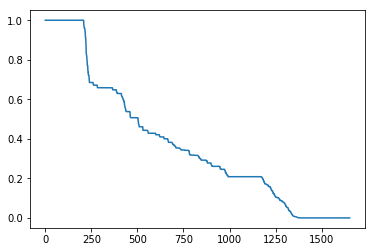

In [33]:

import numpy as np
import matplotlib.pyplot as plt
def calc_similarity(com_date_stock300, distance = 'cos' ):
    # 计算相似度
    similarity = []
    for i,vec1 in enumerate(com_date_stock300):
        k = i+1
        # if i >2: break
        for j in range(len(com_date_stock300))[k:]:
            vec2 = com_date_stock300[j]
            vector1 = np.array([i+0.00000000001 for i in vec1[3]])
            vector2 = np.array([i+0.00000000001 for i in vec2[3]])
            cos =np.dot(vector1,vector2)/ (np.linalg.norm(vector1)*(np.linalg.norm(vector2)))  
            similarity.append([vec1[:3], vec2[:3], cos])

    similarity = sorted(similarity, key = lambda x: x[2], reverse = True)


    simi = []
    for s in similarity:
        simi.append(s[2])



    x = np.arange(0, len(simi));
    y = np.array(simi)
    plt.plot(x, y)
    plt.show()
    return similarity


# print(tt[0])
# print([i[:3] + i[3][:300] for i in tt[:3]])
# si_t = calc_similarity([i[:3] + [i[3][:23]] for i in tt])

top  100


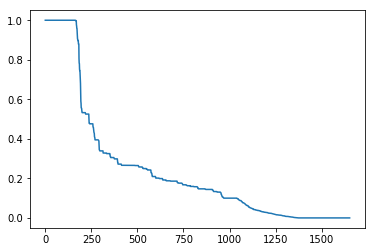

top  200


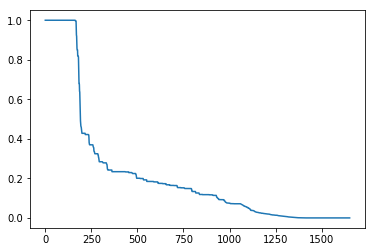

top  300


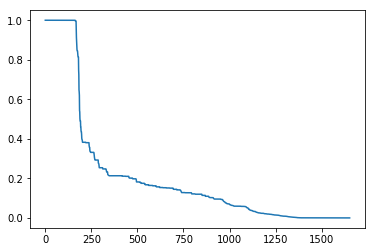

top  400


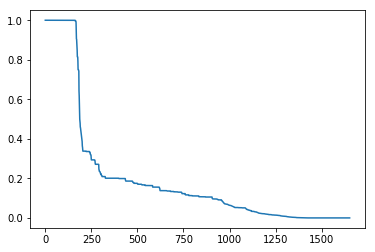

top  500


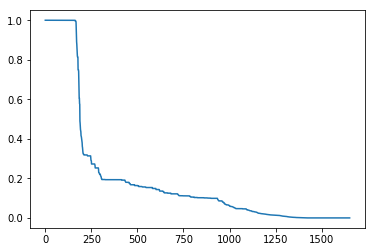

top  600


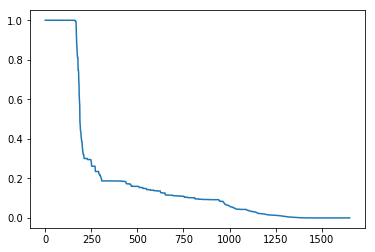

top  700


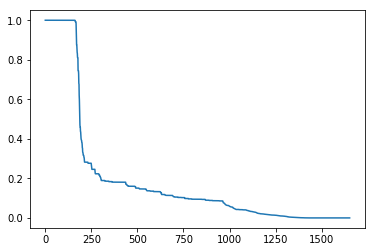

top  800


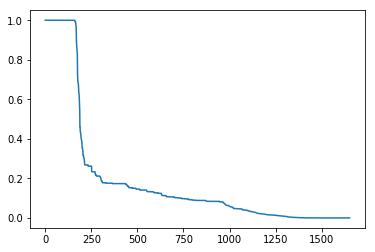

In [44]:
def print_topki(vecs, s,e,step):
    for j in range(s,e,step):
        print("top ",j)
        si_t = calc_similarity([i[:3] + [i[3][:j]] for i in vecs])
        
print_topki(tt, 100, 900, 100)

top  10


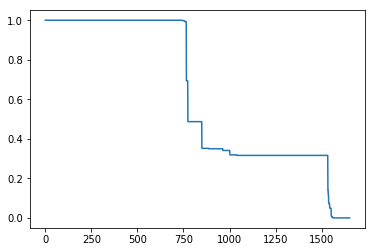

top  110


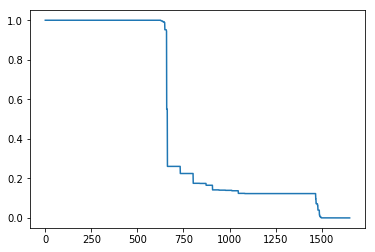

top  210


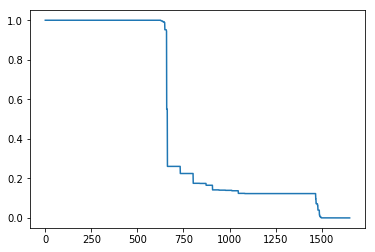

top  310


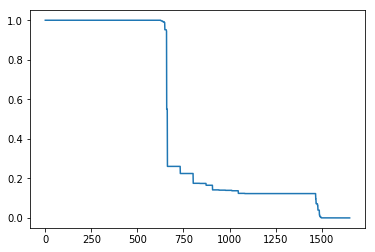

top  410


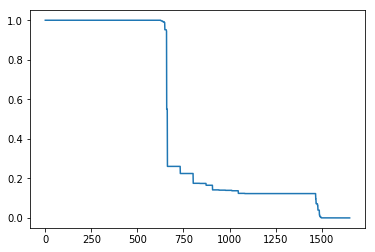

top  10


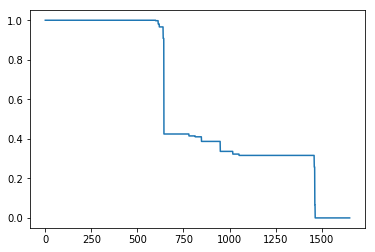

top  110


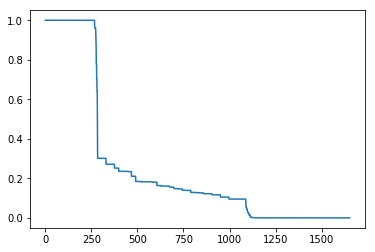

top  210


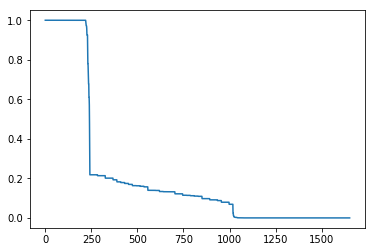

top  310


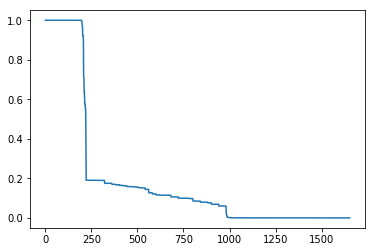

top  410


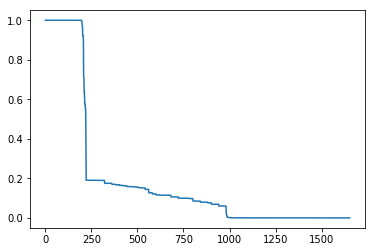

In [47]:





MinimumCapital_keys = {
    
    # "1.外汇 forex MR27 MR28 MR29 hold" 
    'forex':[
        "ExchangeRateRiskForeignCurrencyDenominatedAssetsLiabilitiesUnhedgedOrIneffectivelyHedgedMinimumCapital",
        "ExchangeRateRiskForeignCurrencyDenominatedAssetsLiabilitiesHighlyEffectivelyHedgedMinimumCapitalOfHedgingPortfolio",
        "ExchangeRateRiskForeignExchangeForwardAssetsLiabilitiesIneffectivelyHedgedMinimumCapitalOfForeignExchangeForwardContracts"],

    # "10.股权 equity MR11 MR15 MR17 MR22 hold"
    'equity':[
        "EquityPriceRiskUnlistedEquitiesMinimumCapital",
        "EquityPriceRiskInfrastructureEquityInvestmentPlansMinimumCapital",
        "EquityPriceRiskUnlistedEquityInvestmentPlansMinimumCapital",
        "EquityPriceRiskLongTermEquityInvestmentsInSubsidiariesJointVenturesAndAssociatedCompaniesMinimumCapital",
    ],
    # 8.股票 stock MR09 MR10 MR19 MR20 MR21 buy
    "stock":[
        "EquityPriceRiskStockNoHedgingAndUnqualifiedHedgingMinimumCapital",
        "EquityPriceRiskStockQualifiedHedgingMinimumCapitalOfHedgingPortfolio",
        "EquityPriceRiskUnlistedEquitiesMinimumCapital",
        "EquityPriceRiskPreferredSharesMinimumCapital",
        "EquityPriceRiskShortPositionOfStockIndexFuturesOutOfEffectivenessMinimumCapital",
    ]   ,

    # 2.产品 product CR06 CR08 CR09 CR10 CR11 CR12 CR13   MR08 MR16  MR18 buy
    "product":[
        "CounterpartyDefaultRiskAssetSecuritizationProductsMinimumCapital",
        "CounterpartyDefaultRiskTrustPlansMinimumCapital",
        "CounterpartyDefaultRiskTrustPlansMinimumCapitalOfUnderlyingAssets",
        "CounterpartyDefaultRiskAssetManagementProductsMinimumCapital",
        "CounterpartyDefaultRiskInfrastructureDebtInvestmentPlansMinimumCapital",
        "CounterpartyDefaultRiskPropertyDebtInvestmentPlansMinimumCapital",
        "CounterpartyDefaultRiskProjectAssetBackedPlansMinimumCapital",
        "InterestRateRiskOtherFixedIncomeProductsMinimumCapital",
        "EquityPriceRiskAssetManagementProductsMinimumCapital",
        "EquityPriceRiskEquityTrustPlansMinimumCapital",
    ],

    # 3.合约 contract MR05 CR14  hold
    "contract":[
        "CounterpartyDefaultRiskForwardForeignExchangeContractsAndInterestRateSwapsForPurposeOfHedgingMinimumCapital",
        "InterestRateRiskInterestRateDerivativesInterestRateSwapsMinimumCapital",
    ],

    # 4.再保险 reinsurance CR15 CR16 CR17 hold
    "reinsurance":[
        "CounterpartyDefaultRiskOutwardReinsuranceAssetsMinimumCapital",
        "CounterpartyDefaultRiskOutwardReinsuranceAssetsMinimumCapital",
        "CounterpartyDefaultRiskInwardReinsuranceAssetsMinimumCapital",
    ],

    # 5.债券 bond MR03 CR05 buy
    "bond":[
        "CounterpartyDefaultRiskEnterpriseBondsCorporateBondsMinimumCapital",
        "InterestRateRiskBondAssetsNoHedgingAndUnqualifiedHedgingMinimumCapital",
    ],

    # 6.资产 assets CR01 buy
    "assets":[
        "CreditRiskMinimumCapitalForSpreadRisk",
    ],

    # 7.房地产 real estate MR23 MR24 hold
    "real_estate":[
        "MarketRiskMinimumCapitalForPropertyPriceRisk",
        "MarketRiskMinimumCapitalForPropertyPriceRisk",
    ],

    # 9.基金 fund MR12 MR13 buy
    "fund":[
        "EquityPriceRiskSecuritiesInvestmentFundMinimumCapital",
        "EquityPriceRiskSecuritiesInvestmentFundMinimumCapital",
    ],



    # 11.境外 overseas MR25 MR26 buy
    "overseas":[
        "MarketRiskMinimumCapitalForOverseasFixedIncomeInvestmentAssetsPriceRisk",
        "MarketRiskMinimumCapitalForOverseasEquityInvestmentAssetsPriceRisk",
    ],

    # 12.可转债 convertible bond  MR14 buy
    "convertible_bond":[
        "EquityPriceRiskConvertibleBondMinimumCapital",
    ],
    # 13.证券 security MR04 MR06 MR07 hold
    "security":[
        "InterestRateRiskAssetSecuritizationProductsMinimumCapital",
        # 下面有两个最低资本
        "InterestRateRiskInterestRateDerivativesGovernmentBondFuturesQualifiedHedgingMinimumCapitalOfHedgedBondPortfolio",    
        "InterestRateRiskInterestRateDerivativesGovernmentBondFuturesQualifiedHedgingMinimumCapitalOfHedgingPortfolio",
        "InterestRateRiskInterestRateDerivativesGovernmentBondFuturesUnqualifiedHedgingMinimumCapital",
    ],


}

MinimumCapital_arrays = {}


for label, keys in MinimumCapital_keys.items():
    MinimumCapital_arrays[label] = get_topk(label, keys, k = 1000)

# for label, vecs in MinimumCapital_arrays.items():
#     print("label is ", label)
#     print("\n\n")
#     print_topki(vecs, 10, 500, 100)

# process vectors

### 获取所有外部节点的虚节点的某个属性 -- 写入csv文件 -- eg股票的最低资本


In [2]:
# 创建exposure_cost csv文件

def get_ownamont_writecsv(label , k=999999, ):
    # count buy companies of each stock 
    cql = "match (o:own_amount)-->(out:%s) \
    where any ( i in keys(o) where  i =~ '.*PurchaseCost.*' )           \
    return count(o) as cc, \
    id(out) as stock_id order by cc desc" % label
    li = graph.data(cql)
    stock_ids = []
    stock_nums = []
    for i in li:
        stock_ids.append(i['stock_id'])
        stock_nums.append(i['cc'])

    # 超级慢！！ 20 mins
    # expo_out=[]
    cost_out=[]

    for com, date, dw_name in results_dwzd_date[:2]:
        # arr 表示feature的值，k维向量； eg 最低资本
        # arr1 = []
        arr2 = []
        # 股票top k
        for i in stock_ids[:k]:
            # 当前 i 股票，单位时间购买的最低资本
            cql = "match (c:company{dwzd_bh :'%s'})-->(d:date{inst_date: '%s'})-[*]->(oa:own_amount)-->(s:%s)\
            where id(s) = %d \
            return oa " %(com, date, label, i)
            cur = graph.run(cql)
            expo_sum = 0
            cost_sum = 0
            while cur.forward():
                oa = cur.current().values()[0]
                # 找到当前最低资本key
                # key = (  set(dict(oa).keys()) & set(min_capital_keys)  ).pop()
                # key1 = [ kk for kk in dict(oa).keys() if "RiskExposure" in kk ]
                key2 = [ kk for kk in dict(oa).keys() if "PurchaseCost" in kk ]
                # if key1 == []:
                #     continue
                # else:
                #     key1 = key1[0]
                if key2 == []:
                    continue
                else:
                    key2 = key2[0]
                # expo_sum += float(oa[key1])
                cost_sum += float(oa[key2])
                
            else:
                # arr1.append(expo_sum)
                arr2.append(cost_sum)
        # expo_out.append([com,date, dw_name, arr1])
        cost_out.append([com,date, dw_name, arr2])
    
    # dic1 = {}
    dic2 = {}
    # for i in expo_out:
    #     dic1 ['-'.join(i[:3])] = i[3]
    for i in cost_out:
        dic2 ['-'.join(i[:3])] = i[3]
    
    # df = pd.DataFrame(  dic1 , index= stock_ids[:k])
    # df.to_csv("./expo_"+label+'.csv')
    df = pd.DataFrame(  dic2 , index= stock_ids[:k])
    df.to_csv("./cost_"+label+'.csv')
        

ex_cost_labels = [
"forex",
"product",
"contract",
"reinsurance",
"bond",
"assets",
"real_estate",
"stock",
"fund",
"equity",
"overseas",
"convertible_bond",
"security",
]  

for exlabel in ex_cost_labels:
    get_ownamont_writecsv(exlabel)

NameError: name 'graph' is not defined